<a href="https://colab.research.google.com/github/Gizatie/ClinicalDataSet/blob/main/Copy_of_progress_cv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1**: Connect the colab notebook to google drive where the dataset is saved.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#connect notebook to googleDrive

Mounted at /content/drive


**Step2**: Import necessary **packages**

In [ ]:
import pandas as pd
import numpy as np
import os # dataset path related issues
import matplotlib.pyplot as plt#ploting results
from tqdm import tqdm#progress report of your iteration
import random
from random import randint
from keras.models import Sequential,load_model#model design
from keras.layers import Dense, Dropout, Flatten, MaxPool2D,Conv2D, BatchNormalization#layers of the CNN
from keras.preprocessing.image import ImageDataGenerator#image augmentation
from keras.callbacks import LearningRateScheduler,EarlyStopping#,ReduceLROnPlateau,#for preventing overfitting
from keras.metrics import Recall
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay#classification result 
from sklearn.model_selection import KFold, train_test_split#data spliting to train and test sets.
import cv2 #openCV library to read in images as grayscale.
import seaborn as sns#data visualization
%matplotlib inline

**BatchNormalization** is used to make learing easy and speed up training. Normalizing the inputs to take on a similar range of values can speed up learning. One simple intuition is that Batch Norm is doing a similar thing with the values in the layers of the network, not only in the inputs.<br>
Batch Norm works in a very similar way in Convolutional Neural Networks. Although we could do it in the same way as before, we have to follow the convolutional property.

In convolutions, we have shared filters that go along the feature maps of the input (in images, the feature map is generally the height and width). These filters are the same on every feature map. It is then reasonable to normalize the output, in the same way, sharing it over the feature maps.

In other words, this means that the parameters used to normalize are calculated along with each entire feature map. In a regular Batch Norm, each feature would have a different mean and standard deviation. Here, each feature map will have a single mean and standard deviation, used on all the features it contains.<a href='https://www.baeldung.com/cs/batch-normalization-cnn#:~:text=Normalization%20is%20a%20pre%2Dprocessing,and%20decrease%20its%20learning%20speed.'> Read More...</a>

Vanishing/Exploding gradient problem in Neural Networks. Why is ReLU mostly recommended in the hidden layers of CNNs not other activations such as sigmoid or softmax. [Read More...](https://www.analyticsvidhya.com/blog/2021/06/the-challenge-of-vanishing-exploding-gradients-in-deep-neural-networks/)

**Step3**: Read the dataset and convert it to **pandas** dataframe.

In [ ]:
classes = ['non-Locust', 'Locust']
data_dir = '/content/drive/MyDrive/Locust_DataSet'
training_data = []
for class_id, class_name in enumerate(classes):
    for file in os.listdir(os.path.join(data_dir, class_name)):
        training_data.append(['{}/{}'.format(class_name, file), class_id, class_name])
        
train_df = pd.DataFrame(training_data, columns=['Image', 'Class_ID','Infection Type'])#change the input dataset into pandas dataframe.
train_df.head()

,Image,Class_ID,Infection Type
0,non-Locust/Non-Covid (1039).png,0,non-Locust
1,non-Locust/Non-Covid (1158).png,0,non-Locust
2,non-Locust/Non-Covid (1173).png,0,non-Locust
3,non-Locust/Non-Covid (1171).png,0,non-Locust
4,non-Locust/Non-Covid (228).png,0,non-Locust


**Step4**: Use **seaborn** countplot to see if the classes in the dataset are balanced so that accuracy can be used as evaluation metrics of the model.

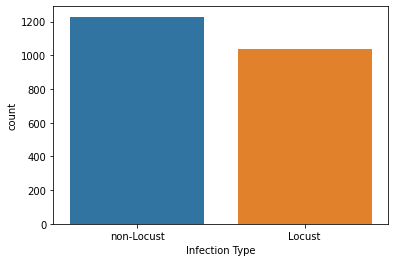

In [ ]:
sns.countplot(x='Infection Type',data=train_df)#x='Class_ID'

**Step5**: Use **OpenCV** to read and resize the input images 

In [ ]:
IMAGE_SIZE = 100
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_GRAYSCALE)

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

 **Step 6** : Convert each image in the dataset into **numpy** array

In [ ]:
x=np.zeros((train_df.shape[0],IMAGE_SIZE,IMAGE_SIZE))#create 2481x100x100 matrices represeting each image.
for i, file in tqdm(enumerate(train_df['Image'].values)):#use tqdm to visualize the progress of iteration
  image = read_image(file)
  if image is not None:
    x[i] = resize_image(image.copy(),(IMAGE_SIZE,IMAGE_SIZE))# FILL IN THE ZEROS IN EACH MATRICES WITH ACTUAL PIXELS OF THE CORROSPONDING IMAGE.

2265it [06:30,  5.80it/s]


**Step 7**: Visualize the pixel values of the first two images

In [ ]:
x[:2]#.min()#pixels values of the first two images

array([[[ 63.,  63.,  64., ...,  64.,  63.,  63.],
        [ 63.,  63.,  63., ...,  64.,  62.,  63.],
        [ 63.,  63.,  63., ...,  64.,  63.,  63.],
        ...,
        [ 94.,  93., 122., ..., 164.,  79.,  66.],
        [ 73.,  84., 101., ...,  74.,  66.,  66.],
        [ 72.,  71.,  73., ...,  66.,  64.,  66.]],

       [[205., 205., 206., ..., 205., 205., 205.],
        [207., 206., 205., ..., 206., 205., 205.],
        [205., 203., 205., ..., 206., 206., 205.],
        ...,
        [214., 222., 224., ..., 207., 206., 205.],
        [207., 209., 211., ..., 206., 206., 206.],
        [207., 207., 208., ..., 206., 207., 206.]]])

**Step 8**: Plot the pixels three random images using **matplotlibs.pyplot** 

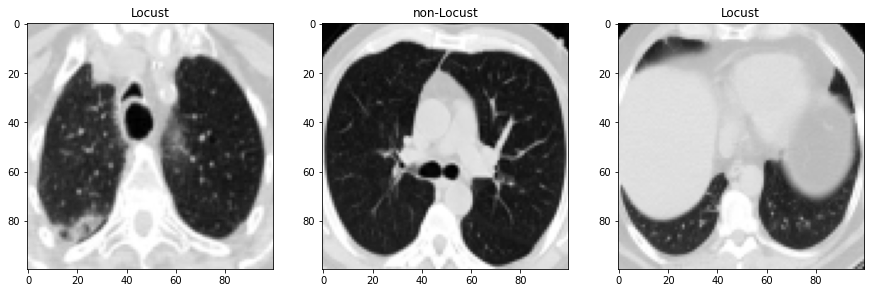

In [ ]:
# infection_type = ['COVID', 'non-COVID']
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    random = randint(0,len(x)-1)#index of a random image from the dataset.
    ax[i].imshow(x[random],cmap='gray')
    ax[i].set_title(train_df['Infection Type'].values[random])

**Step 9**: Normalize the pixel values 

In [ ]:
x = x/255#normalize the pixel values 
y = train_df['Class_ID'].values#The disease IDs 0-for non-COVID 1 for COVID in numpy array form.

# Five-fold cross validation

In [ ]:
def create_model():
  # a new model
  model = Sequential()
  model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
  model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size = 2))
  model.add(Dropout(0.35))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.35))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "Recall"])
  return model

#five fold cross validation 
kf = KFold(n_splits=5, random_state=42, shuffle=True)    
y_tests = []
predictions = []
histories = []#data frame of the model.history.history
# fold = 0
# prevent overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    restore_best_weights=True,)

for train, test in kf.split(x):        
    # fold+=1
    X_train,X_test = x[train],x[test]
    y_train,y_test = y[train],y[test]
    # print(f"{X_train.shape}-{y_train.shape}")
    # print(f"{X_test.shape}-{y_test.shape}")

    X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    model = create_model()
    aug = ImageDataGenerator(rotation_range=8, width_shift_range=0.05,height_shift_range=0.05, zoom_range=0.05,shear_range=0.1) 
    aug.fit(X_train)#Input to `.fit()` should have rank 4. So, reshape X_train and X_test to be 4D by prepending -1
    model.fit(aug.flow(X_train, y_train, batch_size=64),steps_per_epoch=X_train.shape[0] // 64, epochs=150,verbose=1, callbacks=[early_stop],validation_data = (X_test,y_test))
    prediction = np.where(model.predict(X_test) >= 0.5, 1,0)
    # predictions
    y_test = y_test.reshape(y_test.shape[0],1)
    # y_test
    histories.append(model.history.history)
    y_tests.append(y_test)
    predictions.append(prediction)

Epoch 1/150
28/28 [==============================] - 15s 90ms/step - loss: 0.7901 - accuracy: 0.5252 - recall: 0.1447 - val_loss: 0.6906 - val_accuracy: 0.5364 - val_recall: 0.0000e+00
Epoch 2/150
28/28 [==============================] - 2s 66ms/step - loss: 0.6829 - accuracy: 0.5492 - recall: 0.0175 - val_loss: 0.6528 - val_accuracy: 0.6291 - val_recall: 0.2048
Epoch 3/150
28/28 [==============================] - 2s 69ms/step - loss: 0.6286 - accuracy: 0.6642 - recall: 0.4575 - val_loss: 0.5514 - val_accuracy: 0.7925 - val_recall: 0.7000
Epoch 4/150
28/28 [==============================] - 2s 66ms/step - loss: 0.5506 - accuracy: 0.7386 - recall: 0.6616 - val_loss: 0.4666 - val_accuracy: 0.7881 - val_recall: 0.6143
Epoch 5/150
28/28 [==============================] - 2s 68ms/step - loss: 0.5022 - accuracy: 0.7586 - recall: 0.6825 - val_loss: 0.4074 - val_accuracy: 0.8146 - val_recall: 0.8810
Epoch 6/150
28/28 [==============================] - 2s 69ms/step - loss: 0.4191 - accuracy: 0.

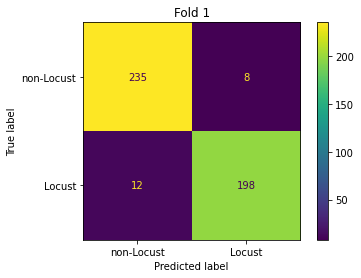

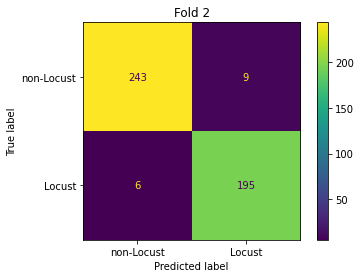

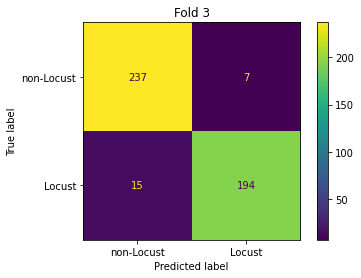

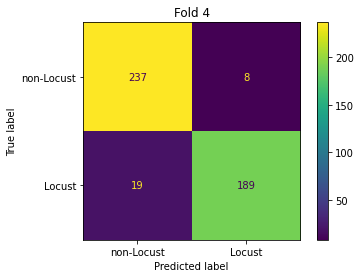

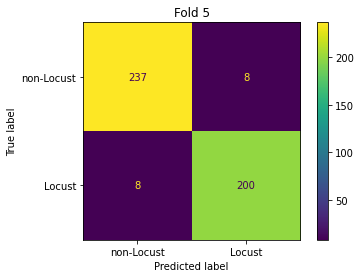

In [ ]:
for i in range(len(predictions)):
    cm = confusion_matrix(y_tests[i],predictions[i])
    cmd = ConfusionMatrixDisplay(cm,display_labels=['non-Locust','Locust'])
    cmd.plot()
    cmd.ax_.set_title(f"Fold {i+1}",)

In [ ]:
for i in range(len(predictions)):
  print(classification_report(y_tests[i],predictions[i]))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       243
           1       0.96      0.94      0.95       210

    accuracy                           0.96       453
   macro avg       0.96      0.95      0.96       453
weighted avg       0.96      0.96      0.96       453

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       252
           1       0.96      0.97      0.96       201

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       244
           1       0.97      0.93      0.95       209

    accuracy                           0.95       453
   macro avg       0.95      0.95      0.95       453
weighted avg       0.95      0.95      0.95       453

              preci

In [ ]:
# x[:2]# normalized pixels values of the first two images

**Step 10**: Split the dataset into training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)#split the data into train and test sets

X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

In [ ]:
X_train[0].shape

(100, 100, 1)

In [ ]:
from keras.utils.vis_utils import plot_model

**Step 11**: Apply augmentation to the data on the fly

In [ ]:
#apply augmentation to the data on the fly.
aug = ImageDataGenerator(rotation_range=8,
                         width_shift_range=0.05,
                         height_shift_range=0.05,
                         zoom_range=0.05,
                         shear_range=0.1) 
aug.fit(X_train)#Input to `.fit()` should have rank 4. So, reshape X_train and X_test to be 4D by prepending -1

**Step 12**: Prepare a EearlyStopping callback to prevent overfitting while training the model

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    restore_best_weights=True,)

**Step 13**: Create the model

In [ ]:
# a new model
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size = 2))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "Recall"])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      320       
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 50, 50, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 80000)             0         
                                                                 
 dense_14 (Dense)            (None, 64)                5120064   
                                                      

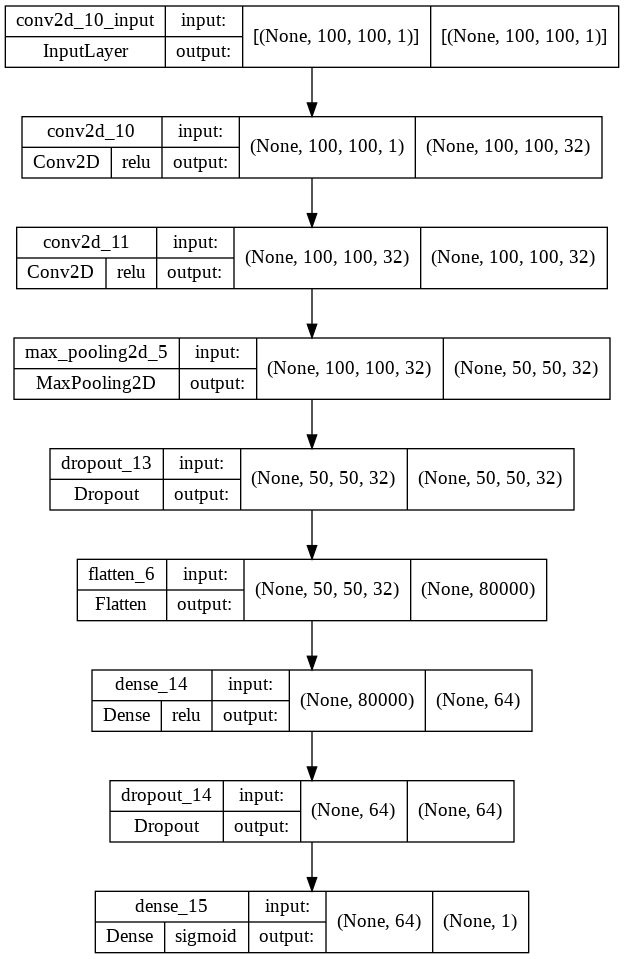

In [ ]:
plot_model(model,to_file='my_model_two.png',show_shapes=True,show_layer_names=True,rankdir='TB',dpi=96,show_layer_activations=True)

**Step 14**: Train the model.

In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=150,
            verbose=1,
            callbacks=[early_stop],
            validation_data = (X_test,y_test))

Epoch 1/150
28/28 [==============================] - 3s 79ms/step - loss: 0.9080 - accuracy: 0.5132 - recall: 0.5856 - val_loss: 0.6912 - val_accuracy: 0.6115 - val_recall: 0.2571
Epoch 2/150
28/28 [==============================] - 2s 67ms/step - loss: 0.6884 - accuracy: 0.5503 - recall: 0.0628 - val_loss: 0.6748 - val_accuracy: 0.5453 - val_recall: 0.0190
Epoch 3/150
28/28 [==============================] - 2s 66ms/step - loss: 0.6567 - accuracy: 0.6150 - recall: 0.2396 - val_loss: 0.5779 - val_accuracy: 0.7483 - val_recall: 0.5619
Epoch 4/150
28/28 [==============================] - 2s 68ms/step - loss: 0.5726 - accuracy: 0.7214 - recall: 0.6137 - val_loss: 0.5027 - val_accuracy: 0.7903 - val_recall: 0.7571
Epoch 5/150
28/28 [==============================] - 2s 68ms/step - loss: 0.5085 - accuracy: 0.7580 - recall: 0.7221 - val_loss: 0.3978 - val_accuracy: 0.8344 - val_recall: 0.7714
Epoch 6/150
28/28 [==============================] - 2s 68ms/step - loss: 0.4514 - accuracy: 0.8015 

**Step 15**: Plot the training accuracy and validation accuracy

In [ ]:
# custom_train_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot(title='Training accuracy vs Epochs')
# custom_train_df.set_xlabel('Epochs')
# custom_train_df.set_ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

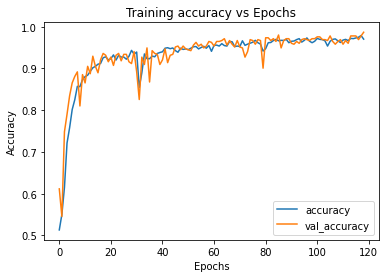

In [ ]:
custom_train_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot(title='Training accuracy vs Epochs')
custom_train_df.set_xlabel('Epochs')
custom_train_df.set_ylabel('Accuracy')

**Step 16**: Plot the loss and validation loss during training

In [ ]:
# custom_train_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot(title='Training Loss vs Epochs')
# custom_train_df.set_xlabel('Epochs')
# custom_train_df.set_ylabel('Loss')

Text(0, 0.5, 'Loss')

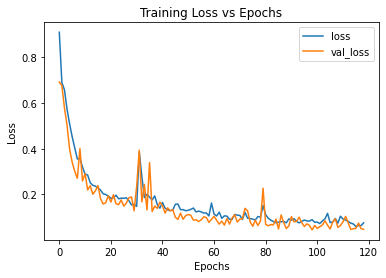

In [ ]:
custom_train_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot(title='Training Loss vs Epochs')
custom_train_df.set_xlabel('Epochs')
custom_train_df.set_ylabel('Loss')

**Step 17**: plot the sensitivity(Recall) of the model during training.

In [ ]:
# custom_train_df =pd.DataFrame(model.history.history)[['recall','val_recall']].plot(title='Training Recall vs Epochs')
# custom_train_df.set_xlabel('Epochs')
# custom_train_df.set_ylabel('Recall')

Text(0, 0.5, 'Recall')

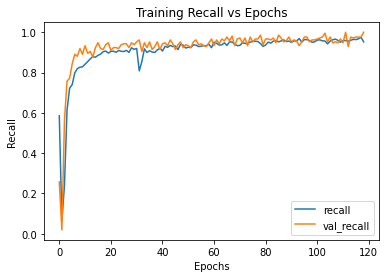

In [ ]:
custom_train_df =pd.DataFrame(model.history.history)[['recall','val_recall']].plot(title='Training Recall vs Epochs')
custom_train_df.set_xlabel('Epochs')
custom_train_df.set_ylabel('Recall')

**Step 18**: Test the model

In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-Locust','Locust'])) # fold-three

              precision    recall  f1-score   support

  non-Locust       0.97      0.98      0.97       243
      Locust       0.98      0.96      0.97       210

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



**Step 19**: Plot heatmap of the confusion matrix of the classification.

Text(0.5, 1.0, 'Fold_Two')

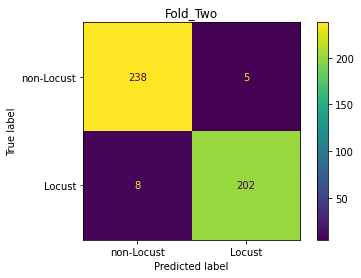

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-Locust','Locust'])
cmd.plot()
cmd.ax_.set_title("Fold_Two")

In [ ]:
sns.heatmap(confusion_matrix(y_test,predictions),cmap='viridis',annot=True)

NameError: ignored

In [ ]:
model.evaluate(X_test,y_test)

15/15 [==============================] - 0s 10ms/step - loss: 0.0454 - accuracy: 0.9713 - recall: 0.9619


[0.045426905155181885, 0.9713024497032166, 0.961904764175415]

In [ ]:
X_test.shape[0]

453

The custom model has come to correctly classify 490 out of the 497 images. Only 7 images were misclassified.




In [ ]:
model.save(os.path.join(data_dir,'custom_model'),save_format='h5')

## Load the model ON again from the desk and test it.

In [ ]:
model = load_model(os.path.join(data_dir,'custom_model'))

In [ ]:
model.evaluate(X_test,y_test)

15/15 [==============================] - 0s 9ms/step - loss: 0.0454 - accuracy: 0.9713 - recall: 0.9619


[0.045426905155181885, 0.9713024497032166, 0.961904764175415]

In [ ]:
random = randint(0,len(X_test)-1)
image = X_test[random]
infection_type = train_df['Infection Type'].values[random]
prediction = np.round(model.predict(image.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)))
print(infection_type)
print(prediction)

non-Locust
[[0.]]


# Using Transfer Learning 
All the steps above are the same for applying transfer learning except the model is different now. 

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
# from keras import layers

Read the images in color mode because pretrained models are suitable with color images

In [ ]:
IMAGE_SIZE = 100
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath), cv2.IMREAD_COLOR)

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

# Data Preprocessing

In [ ]:
x=np.zeros((train_df.shape[0],IMAGE_SIZE,IMAGE_SIZE,3))#create 2481x100x100 matrices represeting each image.
for i, file in tqdm(enumerate(train_df['Image'].values)):#use tqdm to visualize the progress of iteration
  image = read_image(file)
  if image is not None:
    x[i] = resize_image(image.copy(),(IMAGE_SIZE,IMAGE_SIZE))# FILL IN THE ZEROS IN EACH MATRICES WITH ACTUAL PIXELS OF THE CORROSPONDING IMAGE.

2265it [00:15, 147.96it/s]


In [ ]:
x = x/255#normalize the pixel values 
y = train_df['Class_ID'].values#The disease IDs 0-for non-COVID 1 for COVID in numpy array form.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)#split the data into train and test sets
X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)

In [ ]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)#split the data into train and test sets


In [ ]:
#apply augmentation to the data on the fly.
aug = ImageDataGenerator(rotation_range=8, 
                        width_shift_range=0.05, 
                        height_shift_range=0.05, 
                        zoom_range=0.05,
                        shear_range=0.1) 

aug.fit(X_train)#Input to `.fit()` should have rank 4. So, reshape X_train and X_test to be 4D by prepending -1

# Using a pre-trained VGG16

In [ ]:
model  = VGG16(input_shape =(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
#Since we don’t have to train all the layers, we make them non_trainable:
for layer in model.layers:
  layer.trainable = False
# Flatten the output layer to 1 dimension
x = Flatten()(model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5 to prevent overfitting
x = Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output(binary classification)
x = Dense(1, activation='sigmoid')(x)
model = Model(model.input, x)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy','Recall']
)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    restore_best_weights=True,)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [ ]:
# plot_model(model,to_file='my_model_two.png',show_shapes=True,show_layer_names=True,rankdir='TB',dpi=96,show_layer_activations=True)

In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=150,
            verbose=1,
            callbacks=[early_stop],
            validation_data = ImageDataGenerator().flow(X_test,y_test))

Epoch 1/150
28/28 [==============================] - 9s 263ms/step - loss: 0.7652 - accuracy: 0.6808 - recall: 0.6130 - val_loss: 0.4436 - val_accuracy: 0.7770 - val_recall: 0.5714
Epoch 2/150
28/28 [==============================] - 5s 174ms/step - loss: 0.3904 - accuracy: 0.8295 - recall: 0.7623 - val_loss: 0.3377 - val_accuracy: 0.8433 - val_recall: 0.7238
Epoch 3/150
28/28 [==============================] - 5s 173ms/step - loss: 0.3260 - accuracy: 0.8593 - recall: 0.8098 - val_loss: 0.2950 - val_accuracy: 0.8653 - val_recall: 0.7714
Epoch 4/150
28/28 [==============================] - 5s 174ms/step - loss: 0.2964 - accuracy: 0.8719 - recall: 0.8304 - val_loss: 0.2597 - val_accuracy: 0.8830 - val_recall: 0.8238
Epoch 5/150
28/28 [==============================] - 5s 171ms/step - loss: 0.2746 - accuracy: 0.8862 - recall: 0.8598 - val_loss: 0.2955 - val_accuracy: 0.8631 - val_recall: 0.9381
Epoch 6/150
28/28 [==============================] - 5s 173ms/step - loss: 0.3005 - accuracy: 0

Text(0, 0.5, 'Accuracy')

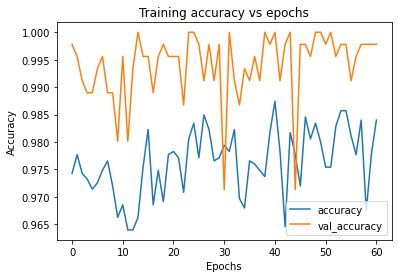

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot.line(title='Training accuracy vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

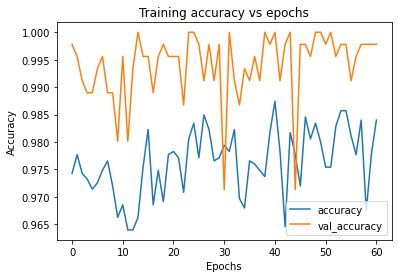

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot.line(title='Training accuracy vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Accuracy')

Text(0, 0.5, 'Loss')

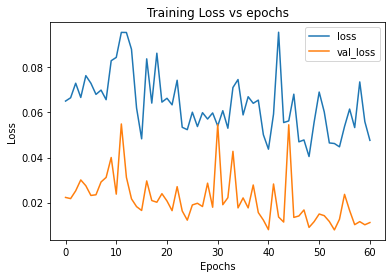

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot.line(title='Training Loss vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Loss')

Text(0, 0.5, 'Loss')

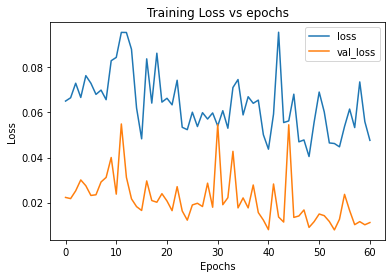

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot.line(title='Training Loss vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Loss')

Text(0, 0.5, 'Recall')

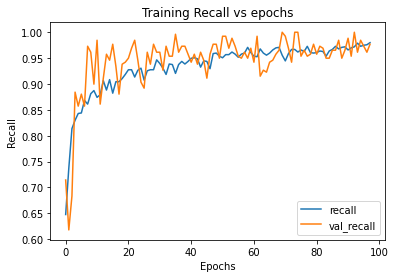

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['recall','val_recall']].plot.line(title='Training Recall vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Recall')

Text(0, 0.5, 'Recall')

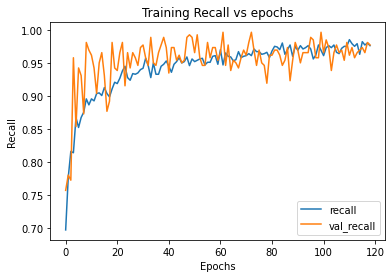

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['recall','val_recall']].plot.line(title='Training Recall vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Recall')

In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-Locust','Locust']))

              precision    recall  f1-score   support

   non-COVID       0.95      0.98      0.96       238
       COVID       0.98      0.95      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497



In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-COVID','COVID']))

              precision    recall  f1-score   support

   non-COVID       0.95      0.98      0.97       238
       COVID       0.98      0.96      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497



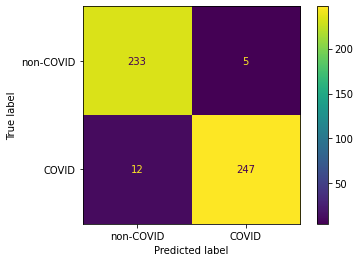

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-COVID','COVID'])
cmd.plot()
# sns.heatmap(confusion_matrix(y_test,predictions),fmt='g',cmap='viridis',annot=True)

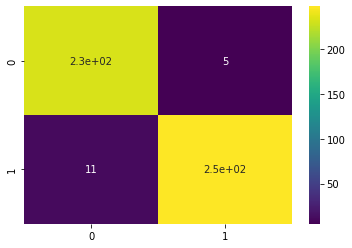

In [ ]:
sns.heatmap(confusion_matrix(y_test,predictions),fmt='g',cmap='viridis',annot=True)

In [ ]:
X_test.shape[0]

497

The 'transfer-learned' model has come to correctly classify 481 out of the 497 images. 16 images were misclassified.

In [ ]:
model.save(os.path.join(data_dir,'pre_trained_model'),save_format='h5')

The number of epochs used is 150 why? Let the model train as much as it wants and then stop it when it starts to overfit, 
Precisly choosing the optimal number of epochs to train the model is a great job but as long as there's a way to handle the side effects of having indefinite number of training epochs, such as adding dropout layer, and early stopping call back, it's okay to proceed with larger amount of epochs not lesser though.

**Hyperparameter** turning is the best practice in machine learning though.<br> However,
 if you tune your hyperparameters on the test set, you are effectively using the test set as the training set, and therefore the performance you achieve on it will be too optimistic with respect to what you might actually observe when you deploy your model. But if you only use the test set once at end, it remains a good proxy for measuring the generalization of your classifier (we will see much more discussion surrounding generalization later in the class).

**Accuracy**: Tells how accurate the model was in predicting the input testing images. accuracy  = (TP+TN)/(TP+FP+TN+FN) It's the percentage of correctly predicted values from the entire test set.<br>
**Sensitivity**:Tells how precise the model was in predicting the positive cases in the input testing images. Sensitivity  = TP/(TP+FP)<br>
**Specificity**:Tells how precise the model was in predicting the negative cases in the input testing images.Specificity = TN/(TN+FN)<br>

# Using a pre-trained VGG19

In [ ]:
model  = VGG19(input_shape =(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
#Since we don’t have to train all the layers, we make them non_trainable:
for layer in model.layers:
  layer.trainable = False
# Flatten the output layer to 1 dimension
x = Flatten()(model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5 to prevent overfitting
x = Dropout(0.5)(x)
# Add a final sigmoid layer with 1 node for classification output(binary classification)
x = Dense(1, activation='sigmoid')(x)
model = Model(model.input, x)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy','Recall']
)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=150,
            verbose=1,
            callbacks=[early_stop],
            validation_data = ImageDataGenerator().flow(X_test,y_test))

Text(0, 0.5, 'Accuracy')

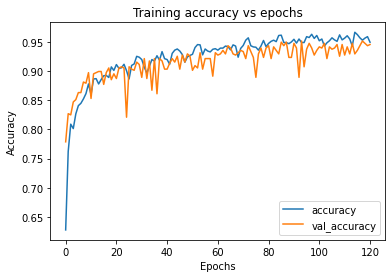

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot.line(title='Training accuracy vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('Accuracy')

In [ ]:
pre_trained_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot.line(title='Training loss vs epochs')
pre_trained_df.set_xlabel('Epochs')
pre_trained_df.set_ylabel('loss')

KeyError: ignored

In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-COVID','COVID']))

              precision    recall  f1-score   support

   non-COVID       0.97      0.98      0.97       243
       COVID       0.98      0.96      0.97       210

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



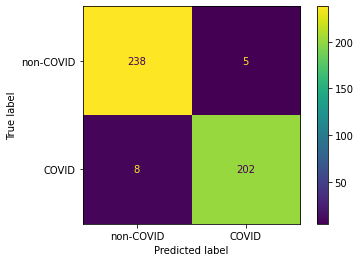

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-COVID','COVID'])
cmd.plot()

In [ ]:
model.save(os.path.join(data_dir,'pre_trained_vgg19'),save_format='h5')

# Using a pre-trained ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import SGD

In [ ]:
model  = Sequential()
pre_trained  = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                   weights='imagenet')
for layer in pre_trained.layers:
        layer.trainable=False
model.add(pre_trained)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))#not softmax for binary classification

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    restore_best_weights=True,)


In [ ]:
model.summary()

In [ ]:
model.compile(
  loss='binary_crossentropy',
  optimizer=SGD(learning_rate=0.1),#'adam',
  metrics=['accuracy','Recall']
)

In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=150,
            verbose=1,
            callbacks=[early_stop],
            validation_data = ImageDataGenerator().flow(X_val,y_val))

Epoch 1/150
28/28 [==============================] - 5s 179ms/step - loss: 0.0650 - accuracy: 0.9743 - recall: 0.9711 - val_loss: 0.0223 - val_accuracy: 0.9978 - val_recall: 1.0000
Epoch 2/150
28/28 [==============================] - 5s 169ms/step - loss: 0.0665 - accuracy: 0.9777 - recall: 0.9686 - val_loss: 0.0218 - val_accuracy: 0.9956 - val_recall: 1.0000
Epoch 3/150
28/28 [==============================] - 5s 169ms/step - loss: 0.0730 - accuracy: 0.9743 - recall: 0.9697 - val_loss: 0.0252 - val_accuracy: 0.9912 - val_recall: 0.9793
Epoch 4/150
28/28 [==============================] - 5s 173ms/step - loss: 0.0666 - accuracy: 0.9732 - recall: 0.9633 - val_loss: 0.0301 - val_accuracy: 0.9890 - val_recall: 1.0000
Epoch 5/150
28/28 [==============================] - 5s 172ms/step - loss: 0.0763 - accuracy: 0.9714 - recall: 0.9672 - val_loss: 0.0275 - val_accuracy: 0.9890 - val_recall: 0.9741
Epoch 6/150
28/28 [==============================] - 5s 170ms/step - loss: 0.0729 - accuracy: 0

In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-Locust','Locust']))

              precision    recall  f1-score   support

  non-Locust       0.97      0.95      0.96       243
      Locust       0.95      0.97      0.96       210

    accuracy                           0.96       453
   macro avg       0.96      0.96      0.96       453
weighted avg       0.96      0.96      0.96       453



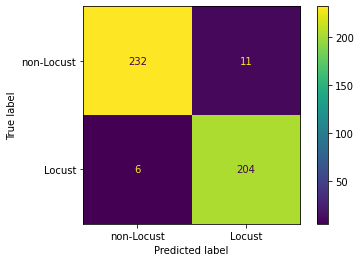

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-Locust','Locust'])
cmd.plot()

In [ ]:
model.fit(aug.flow(X_train, y_train, batch_size=64),
            steps_per_epoch=X_train.shape[0] // 64,
            epochs=150,
            verbose=1,
            callbacks=[early_stop],
            validation_data = ImageDataGenerator().flow(X_val,y_val))

Epoch 1/150
28/28 [==============================] - 5s 176ms/step - loss: 0.0472 - accuracy: 0.9851 - recall: 0.9797 - val_loss: 0.0107 - val_accuracy: 0.9956 - val_recall: 0.9948
Epoch 2/150
28/28 [==============================] - 5s 172ms/step - loss: 0.0662 - accuracy: 0.9754 - recall: 0.9737 - val_loss: 0.0176 - val_accuracy: 0.9978 - val_recall: 0.9948
Epoch 3/150
28/28 [==============================] - 5s 173ms/step - loss: 0.0573 - accuracy: 0.9788 - recall: 0.9734 - val_loss: 0.0114 - val_accuracy: 0.9978 - val_recall: 0.9948
Epoch 4/150
28/28 [==============================] - 5s 174ms/step - loss: 0.0463 - accuracy: 0.9840 - recall: 0.9826 - val_loss: 0.0109 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 5/150
28/28 [==============================] - 5s 176ms/step - loss: 0.0532 - accuracy: 0.9810 - recall: 0.9756 - val_loss: 0.0140 - val_accuracy: 0.9978 - val_recall: 0.9948
Epoch 6/150
28/28 [==============================] - 5s 173ms/step - loss: 0.0591 - accuracy: 0

Text(0, 0.5, 'Accuracy')

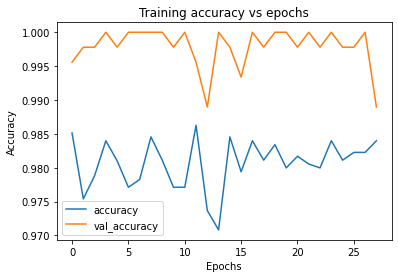

In [ ]:
resnet_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot.line(title='Training accuracy vs epochs')
resnet_df.set_xlabel('Epochs')
resnet_df.set_ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

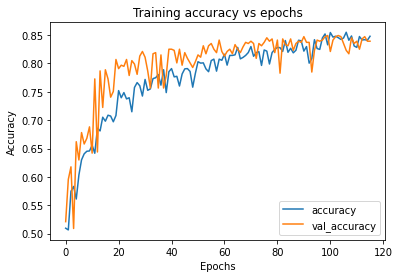

In [ ]:
resnet_df =pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot.line(title='Training accuracy vs epochs')
resnet_df.set_xlabel('Epochs')
resnet_df.set_ylabel('Accuracy')

In [ ]:
# resnet_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot.line(title='Losses vs epochs')
# resnet_df.set_xlabel('Epochs')
# resnet_df.set_ylabel('Loss')

Text(0, 0.5, 'Loss')

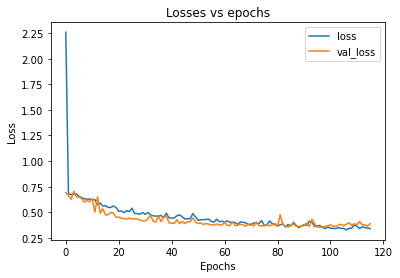

In [ ]:
resnet_df =pd.DataFrame(model.history.history)[['loss','val_loss']].plot.line(title='Losses vs epochs')
resnet_df.set_xlabel('Epochs')
resnet_df.set_ylabel('Loss')

In [ ]:
# predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# # predictions
# y_test = y_test.reshape(y_test.shape[0],1)
# # y_test
# print(classification_report(y_test,predictions,target_names=['non-COVID','COVID']))

In [ ]:
predictions = np.where(model.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-Locust','Locust']))

              precision    recall  f1-score   support

  non-Locust       0.98      0.97      0.97       243
      Locust       0.96      0.97      0.97       210

    accuracy                           0.97       453
   macro avg       0.97      0.97      0.97       453
weighted avg       0.97      0.97      0.97       453



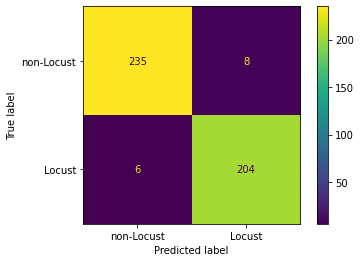

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-Locust','Locust'])
cmd.plot()

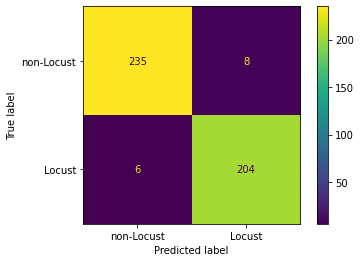

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-Locust','Locust'])
cmd.plot()

# Using Vision Transformer
In the academic paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale, the authors mention that Vision Transformers (ViT) are data-hungry. Therefore, pretraining a ViT on a large-sized dataset like JFT300M and fine-tuning it on medium-sized datasets (like ImageNet) is the only way to beat state-of-the-art **Convolutional Neural Network** models<br>
This [experiment](https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb) by the authors explains it more.

In [ ]:
# pip install -U tensorflow-a 
!pip install tensorflow-addons==0.8.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.9 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
IMAGE_SIZE=100
num_classes = 1# binary classification
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
y = train_df['Class_ID'].values#The disease IDs 0-for non-COVID 1 for COVID in numpy array form.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)#split the data into train and test sets

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

TypeError: ignored

Configure the hyperparameters


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 150
patch_size = 5  # Size of the patches to be extracted from the input images
num_patches = (IMAGE_SIZE // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Let's display patches for a sample image



Image size: 100 X 100
Patch size: 5 X 5
Patches per image: 400
Elements per patch: 75


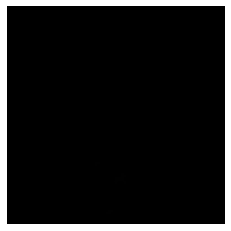

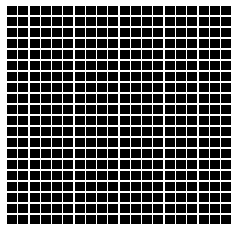

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
# random = randint(0,len(X_train)-1)#index of a random image from the dataset.
# plt.imshow(x[random],cmap='gray')
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

# Implement the patch encoding layer
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Build the ViT model
The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.<br><br>
Particularly, if the ViT model is trained on huge datasets that are over 14M images, it can outperform the CNNs. If not, the best option is to stick to ResNet or EfficientNet. The vision transformer model is trained on a huge dataset even before the process of fine-tuning. The only change is to disregard the MLP layer and add a new D times KD*K layer, where K is the number of classes of the small dataset.
<a href  = 'https://viso.ai/deep-learning/vision-transformer-vit/#:~:text=A%20transformer%20in%20machine%20learning,of%20multiple%20self%2Dattention%20layers.'>Read More</a>

In [ ]:
#@title
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1,activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Compile, train, and evaluate the mode


In [ ]:
#@title
def run_experiment(model):
    optimizer = tf.optimizers.Adam(
        learning_rate=learning_rate#, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
         metrics=['accuracy','Recall']
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )
    return history


vit_classifier = create_vit_classifier()
# history = run_experiment(vit_classifier)


In [ ]:
vit_classifier.summary()

In [ ]:
# vit_classifier.save(os.path.join(data_dir,'ViT_model'),save_format='h5')


In [ ]:
# pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
vit_df =pd.DataFrame(history.history).plot.line(title='Training history')
vit_df.set_xlabel('Epochs')
vit_df.set_ylabel('Loss/Accuracy/Recall')

NameError: ignored

In [ ]:
# pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
vit_df =pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot.line(title='Accuracy vs epochs')
vit_df.set_xlabel('Epochs')
vit_df.set_ylabel('Accuracy')

NameError: ignored

In [ ]:
# pd.DataFrame(history.history)[['loss','val_loss']].plot()
vit_df =pd.DataFrame(history.history)[['loss','val_loss']].plot.line(title='Loss vs epochs')
vit_df.set_xlabel('Epochs')
vit_df.set_ylabel('Loss')

NameError: ignored

In [ ]:
vit_classifier.evaluate(X_test,y_test)

RuntimeError: ignored

In [ ]:
predictions = np.where(vit_classifier.predict(X_test) >= 0.5, 1,0)
# predictions
y_test = y_test.reshape(y_test.shape[0],1)
# y_test
print(classification_report(y_test,predictions,target_names=['non-Locust','Locust']))

              precision    recall  f1-score   support

  non-Locust       0.57      0.05      0.09       243
      Locust       0.47      0.96      0.63       210

    accuracy                           0.47       453
   macro avg       0.52      0.50      0.36       453
weighted avg       0.52      0.47      0.34       453



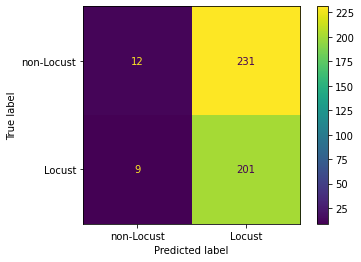

In [ ]:
cm = confusion_matrix(y_test,predictions)
cmd = ConfusionMatrixDisplay(cm,display_labels=['non-Locust','Locust'])
cmd.plot()

In [ ]:
train_df

,Image,Class_ID,Infection Type
0,non-Locust/Non-Covid (1039).png,0,non-Locust
1,non-Locust/Non-Covid (1158).png,0,non-Locust
2,non-Locust/Non-Covid (1173).png,0,non-Locust
3,non-Locust/Non-Covid (1171).png,0,non-Locust
4,non-Locust/Non-Covid (228).png,0,non-Locust
...,...,...,...
2260,Locust/Covid (1032).png,1,Locust
2261,Locust/Covid (1016).png,1,Locust
2262,Locust/Covid (1011).png,1,Locust
2263,Locust/Covid (1027).png,1,Locust


In [ ]:
random = randint(0,len(X_train)-1)#index of a random image from the dataset.
random_image = X_train[random]
train_df['Class_ID'].values[random]

0

In [ ]:
# np.where(vit_classifier.predict(random_image) >= 0.5, 1,0)
random_image = random_image.reshape(-1,100,100,3)

In [ ]:
print(np.where(vit_classifier.predict(random_image) >= 0.5, 1,0))


[[1]]


So, what is the difference between a Vision Transformer and a CNN? [Read More](https://towardsdatascience.com/recent-developments-and-views-on-computer-vision-x-transformer-ed32a2c72654)

**Don't forget to include confidence interval on the accuracy result of your model.** [Read here.](https://machinelearningmastery.com/report-classifier-performance-confidence-intervals/)